In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all the **Dependencies**

In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
target_count = 987  # Target number of images for no_appendicitis
no_appendicitis_path = 'path_to_no_appendicitis_folder'  # Replace with the actual path
augmented_no_appendicitis_path = 'path_to_augmented_no_appendicitis_folder'  # Replace with the actual path

# Ensure the directory exists
os.makedirs(augmented_no_appendicitis_path, exist_ok=True)

# Load and resize images
def load_and_resize_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            resized_img = cv2.resize(img, (img_size, img_size))
            images.append(resized_img)
    return images

# Augment images to reach target count
def augment_images(images, target_count, output_folder):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = np.array(images)
    augmented_images = []

    while len(augmented_images) + len(images) < target_count:
        for img in images:
            img = img.reshape((1,) + img.shape)  # Reshape to (1, img_size, img_size, 3)
            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)  # Get the augmented image and convert to uint8
            augmented_images.append(aug_img)
            if len(augmented_images) + len(images) >= target_count:
                break

    for i, img in enumerate(augmented_images):
        save_path = os.path.join(output_folder, f"aug_no_appendicitis_{i + len(images)}.jpg")
        cv2.imwrite(save_path, img)

    print(f"Augmented {len(augmented_images)} images to match the target count.")

# Main execution
no_appendicitis_images = load_and_resize_images(no_appendicitis_path)
augment_images(no_appendicitis_images, target_count, augmented_no_appendicitis_path)


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_no_appendicitis_folder'

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


Set all the **Constants**

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

Import data into tensorflow dataset **object**

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/US_updated",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1974 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['appendicitis', 'no_appendicitis']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1]



Visualize some of the images from our **dataset**

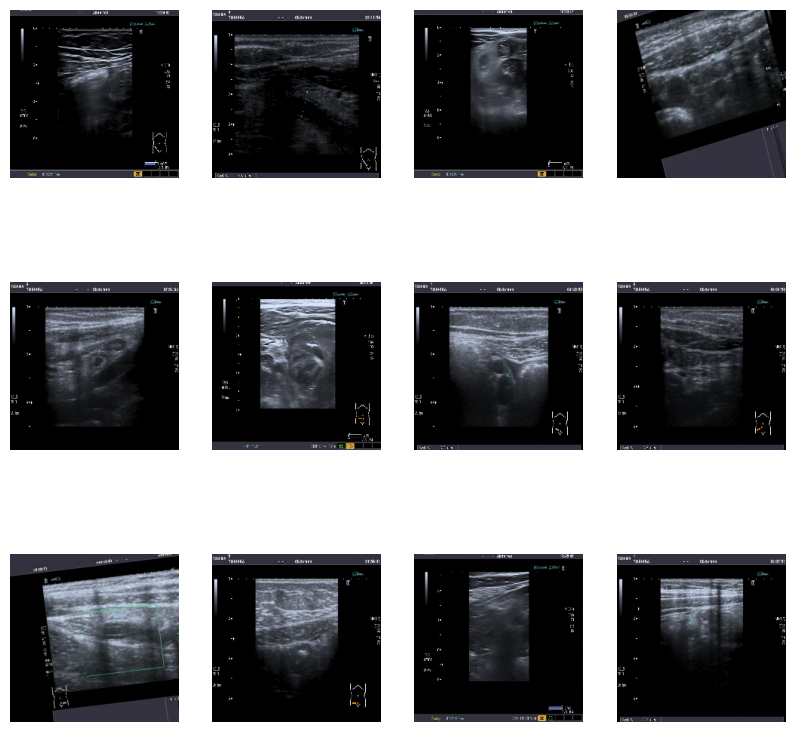

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

**Function to Split Dataset**

Dataset should be converted into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)


62

In [10]:
train_size = 0.8
len(dataset)*train_size


49.6

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**


Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired
size. Moreover, to improve model performance, we should normalize the image
pixel value (keeping them in range 0 and 1 by dividing by 256). This should
happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Applying Data Augmentation to Train Dataset**


**Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Define input shape

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define data preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Load the pre-trained VGG16 model without the top classification layer
base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the convolutional base
base_model.trainable = False

# Build the model
modelresnet = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(2, activation='softmax')  # Assuming binary classification
])

# Compile the model
modelresnet.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [17]:
history = modelresnet.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 399s 779ms/step - accuracy: 0.5067 - loss: 3.8647 - val_accuracy: 0.5055 - val_loss: 0.6911
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - accuracy: 0.5262 - loss: 0.6954 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.5190 - loss: 0.6975 - val_accuracy: 0.4945 - val_loss: 0.6932
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - accuracy: 0.4844 - loss: 0.6973 - val_accuracy: 0.4945 - val_loss: 0.6932
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.5081 - loss: 0.6931 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.4887 - loss: 0.6923 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 295ms/step - accuracy: 0.5090 - loss: 0.6923 - val_accuracy: 0.5055 - val_loss: 0.6931
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.5203 - loss: 0.6936 - val_acc

**Run prediction on a sample image**

first image to predict
actual label: no_appendicitis
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: no_appendicitis


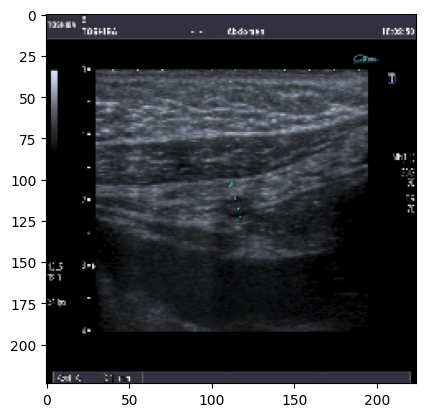

In [18]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = modelresnet.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [19]:
def predict(modelresnet, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = modelresnet.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


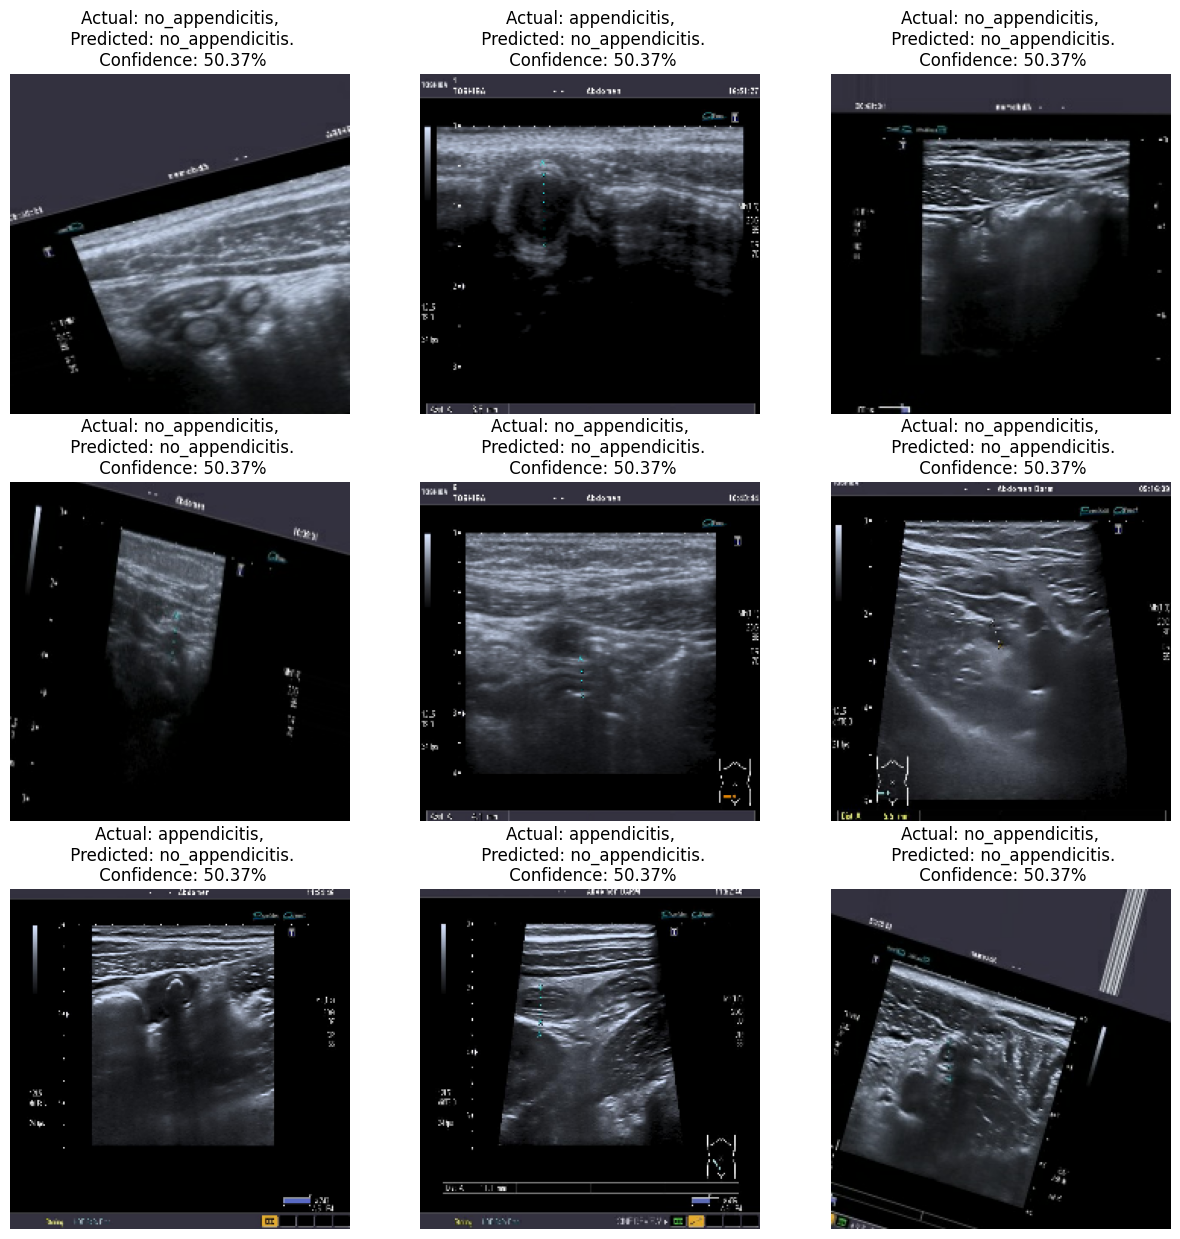

In [20]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(modelresnet, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**saving our model**

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Define input shape

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define data preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the convolutional base
base_model.trainable = False

# Build the model
modelvgg = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(2, activation='softmax')  # Assuming binary classification
])

# Compile the model
modelvgg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
history = modelvgg.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 618ms/step - accuracy: 0.6342 - loss: 0.9195 - val_accuracy: 0.6868 - val_loss: 0.5416
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - accuracy: 0.7215 - loss: 0.5253 - val_accuracy: 0.7912 - val_loss: 0.4461
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.7507 - loss: 0.4961 - val_accuracy: 0.7912 - val_loss: 0.4895
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.7746 - loss: 0.4733 - val_accuracy: 0.7802 - val_loss: 0.4558
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.7531 - loss: 0.4710 - val_accuracy: 0.7967 - val_loss: 0.4510
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.7678 - loss: 0.4894 - val_accuracy: 0.7857 - val_loss: 0.4951
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.7675 - loss: 0.4794 - val_accuracy: 0.7802 - val_loss: 0.4619
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - accuracy: 0.7672 - loss: 0.4620 - val_accu

first image to predict
actual label: no_appendicitis
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
predicted label: no_appendicitis


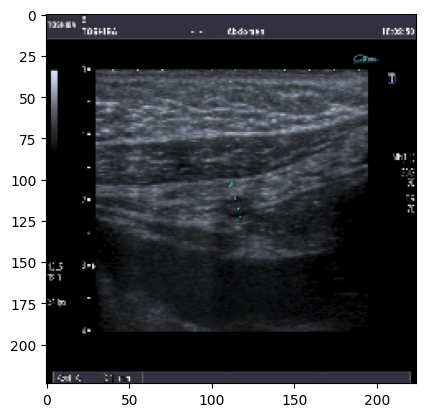

In [25]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = modelvgg.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(modelvgg, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = modelvgg.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


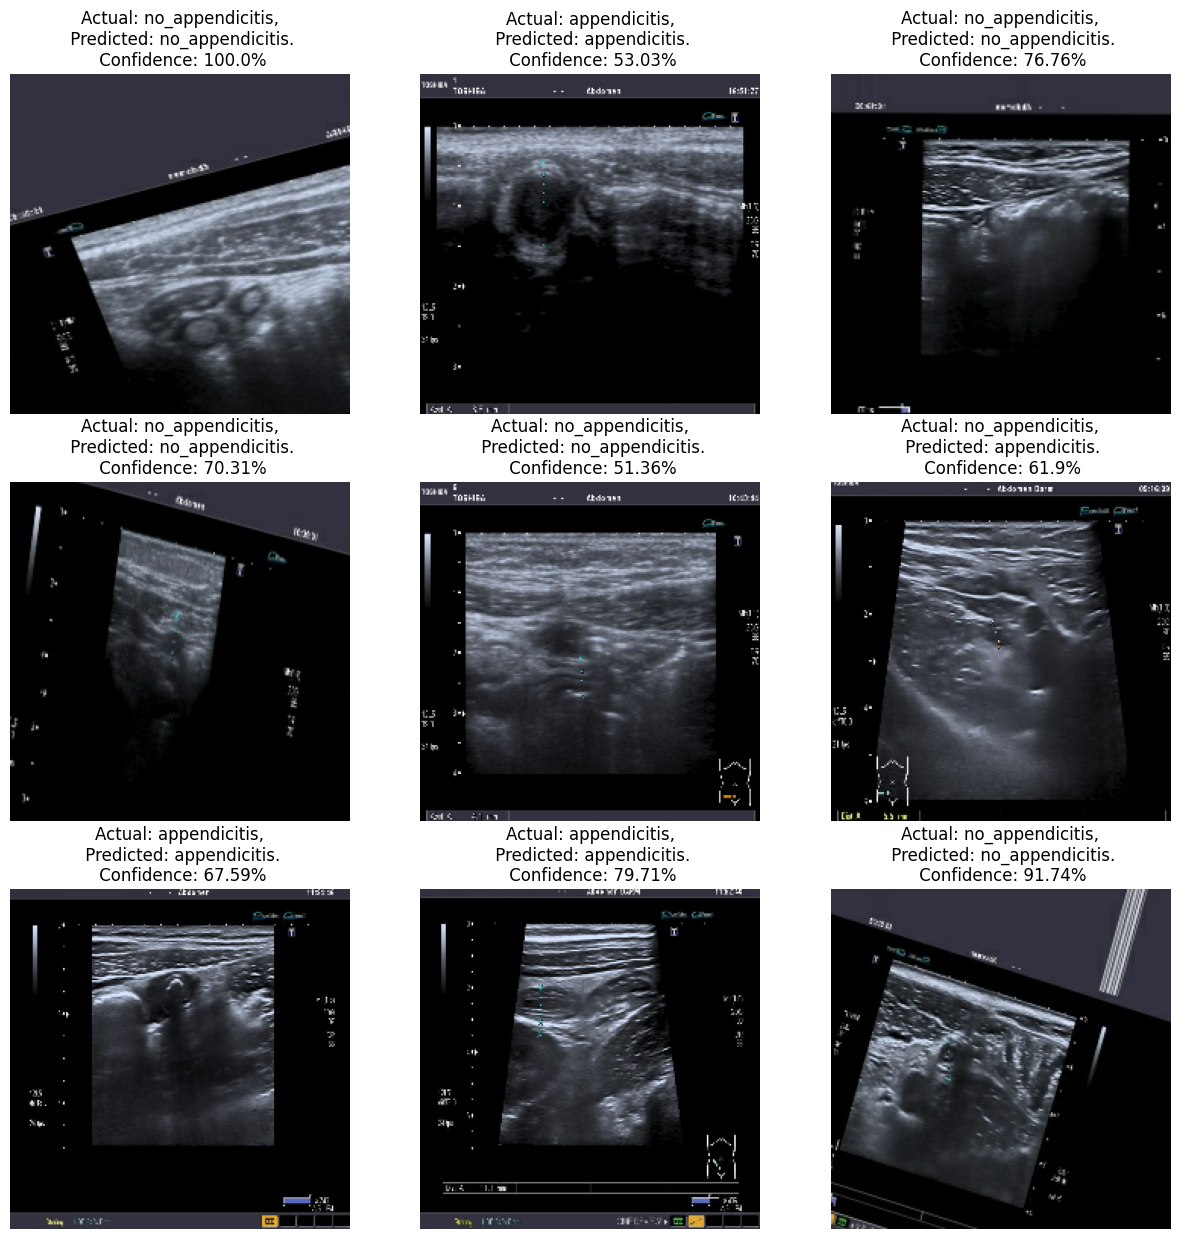

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(modelvgg, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [26]:


# Define input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define data preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Build the model
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(2, activation='softmax')
])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 424ms/step - accuracy: 0.5474 - loss: 0.6892 - val_accuracy: 0.6648 - val_loss: 0.6348
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - accuracy: 0.7343 - loss: 0.5649 - val_accuracy: 0.7473 - val_loss: 0.6902
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - accuracy: 0.7692 - loss: 0.5013 - val_accuracy: 0.6319 - val_loss: 1.1239
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.8047 - loss: 0.4447 - val_accuracy: 0.6374 - val_loss: 0.9836
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.8048 - loss: 0.4270 - val_accuracy: 0.7253 - val_loss: 0.7835
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step - accuracy: 0.8072 - loss: 0.4201 - val_accuracy: 0.6319 - val_loss: 0.8027
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.8081 - loss: 0.4186 - val_accuracy: 0.6319 - val_loss: 0.8052
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - accuracy: 0.8199 - loss: 0.3971 - val_accu

first image to predict
actual label: no_appendicitis
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
predicted label: appendicitis


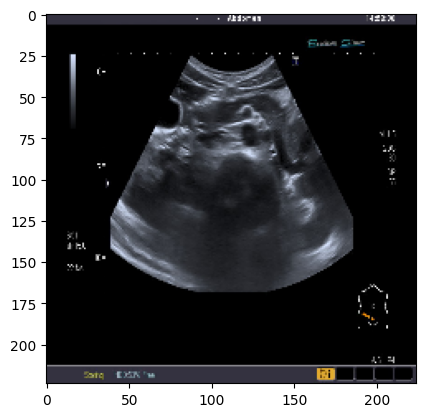

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


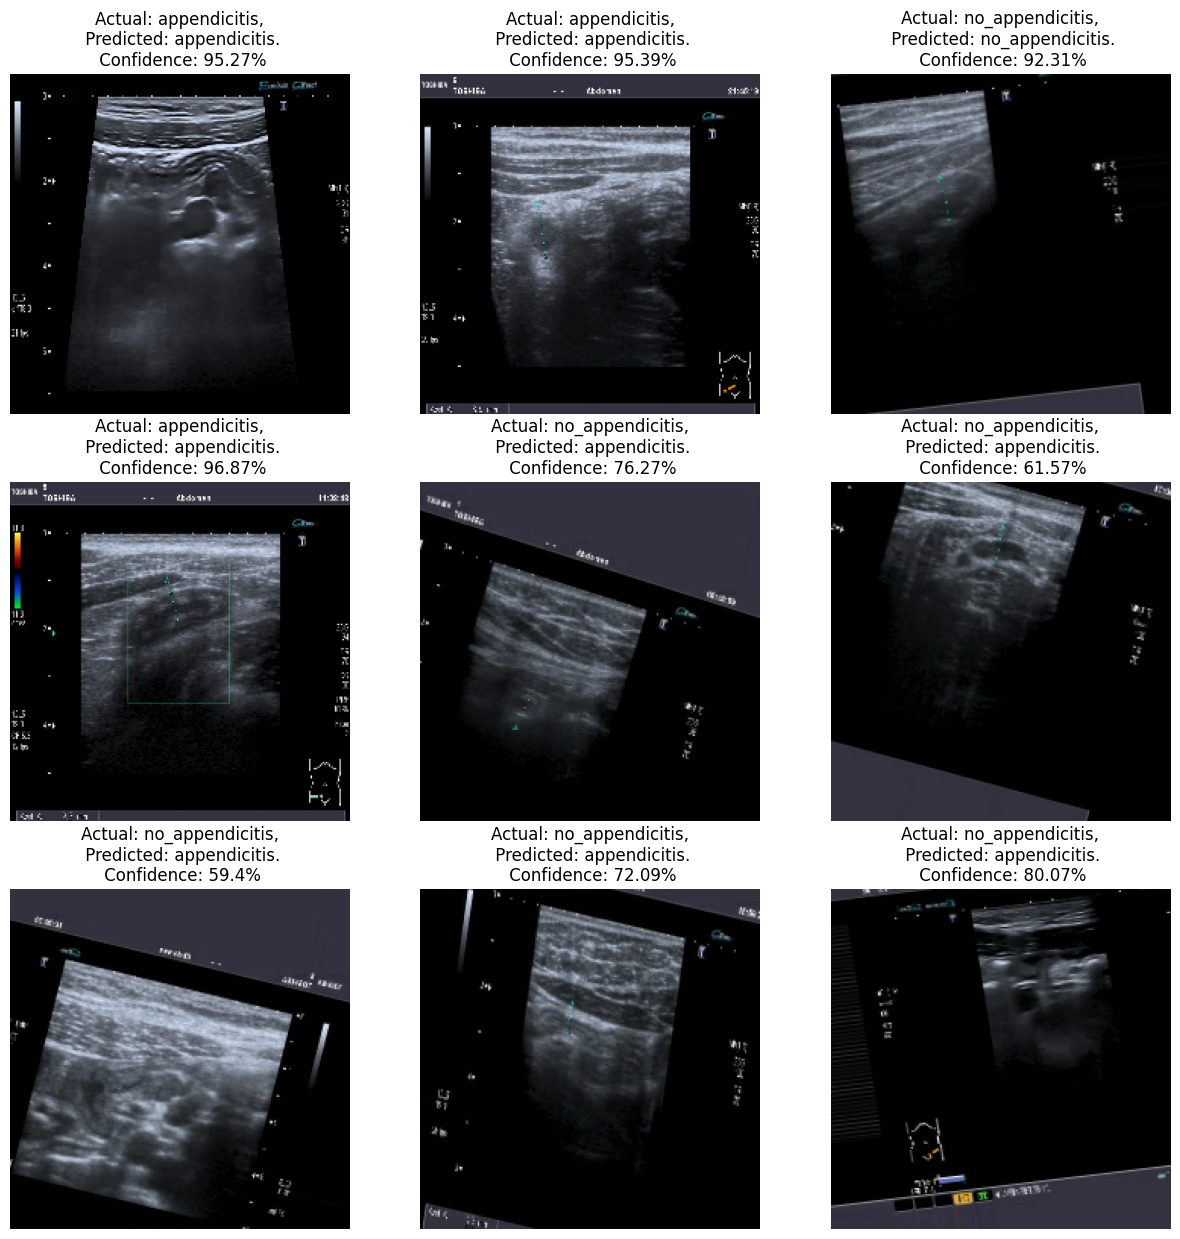

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [37]:
# Evaluate the custom model
custom_model_eval = model.evaluate(val_ds)

# Evaluate the VGG16 model
vgg_eval = modelvgg.evaluate(val_ds)

# Evaluate the ResNet50 model
resnet_eval = modelresnet.evaluate(val_ds)

print("\nComparison of Model Performance:")
print(f"Custom Model - Loss: {custom_model_eval[0]:.4f}, Accuracy: {custom_model_eval[1]:.4f}")
print(f"VGG16 Model - Loss: {vgg_eval[0]:.4f}, Accuracy: {vgg_eval[1]:.4f}")
print(f"ResNet50 Model - Loss: {resnet_eval[0]:.4f}, Accuracy: {resnet_eval[1]:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5642 - loss: 1.1364
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8193 - loss: 0.4561
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5237 - loss: 0.6928

Comparison of Model Performance:
Custom Model - Loss: 1.0517, Accuracy: 0.5824
VGG16 Model - Loss: 0.4519, Accuracy: 0.7967
ResNet50 Model - Loss: 0.6931, Accuracy: 0.5055


In [38]:
modelresnet.save("/content/drive/MyDrive/appendix_prediction/saved_model/appendix_prediction(restnet).keras")
model.save("/content/drive/MyDrive/appendix_prediction/saved_model/appendix_prediction(custom).keras")
modelvgg.save("/content/drive/MyDrive/appendix_prediction/saved_model/appendix_prediction(vgg).keras")